In [12]:
%load_ext autoreload
%autoreload 2

# Machine Learning Analysis

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import joblib

from utils.helper_functions import split_data

In [5]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))

In [6]:
train_df, val_df, test_df = split_data(cancer_df)

In [9]:
train_df.loc[:, numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df.loc[:, numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df.loc[:, numeric_cols] = scaler.transform(test_df[numeric_cols])

In [23]:
from utils.helper_functions import plot_regression_results_sklearn, get_features_and_target


model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
)
train_features, train_target = get_features_and_target(train_df)
model.fit(train_features, train_target)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=1000, random_state=42)

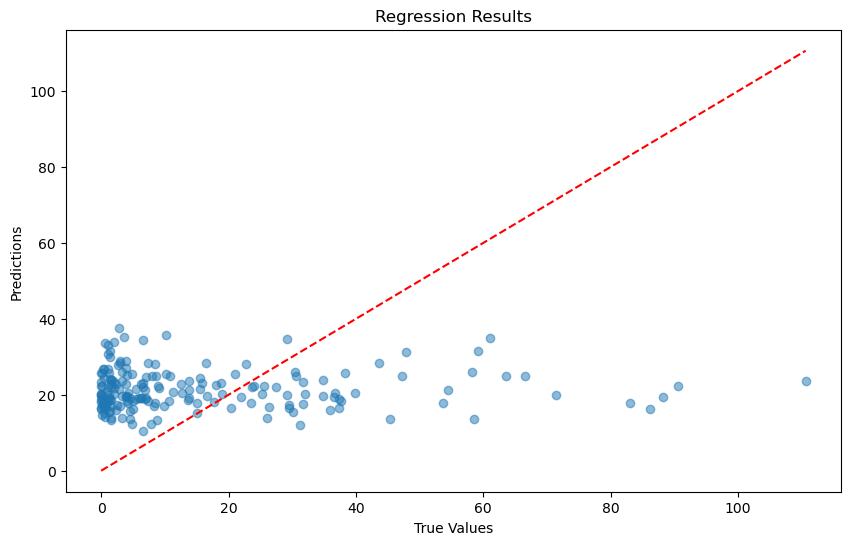

In [21]:
plot_regression_results_sklearn(model, test_df)

In [ ]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
    )
    train_features, train_target = get_features_and_target(train_df)
    val_features, val_target = get_features_and_target(val_df)


    model.fit(train_features, train_target)
    return  model.score(val_features, val_target)
